In [1]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm
from tqdm.notebook import tqdm
from yaml import dump, load, safe_load

In [2]:
sys.path.append("../../sql")
import queries

sys.path.append("../source")
from ts_tools import SARIMA_optimizer, gen_sarima_params

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [5]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [6]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [7]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [8]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [9]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
# df.head(5)

In [10]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [20]:
columns = df.columns.tolist()
print(columns)
forecast_on_idx = 4

['Clearsky_DNI', 'DNI', 'Clearsky_GHI', 'GHI', 'Temperature', 'Relative_Humidity', 'Precipitable_Water', 'Wind_Speed']


In [21]:
sarima_order = gen_sarima_params(
    p_rng=(1, 1),
    d_rng=(1, 1),
    q_rng=(1, 1),
    P_rng=(1, 1),
    D_rng=(1, 1),
    Q_rng=(1, 1),
    debug=True,
)

SARIMA Order list length: 1


In [22]:
results = SARIMA_optimizer(df_rsm[columns[forecast_on_idx]], sarima_order, s=12, debug=False)
best_order = results.iloc[0]["(p, d, q, P, D, Q, s)"]

best_order

# (1, 1, 1, 1, 1, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

[[(1, 1, 1, 1, 1, 1), 1009.6255204621842]]

(1, 1, 1, 1, 1, 1)

In [23]:
def sarima_model(series, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, num_fc=1, summary=False, forecast=False):
    """
    input: Pandas Series with pd.datetime index.
           Integers: ARIMA parameters p, d, q
           Integer: number of forecast periods
           Boolean: summary print
           Bookean: True return forecast, False return model
    functionality: perform an ARIMA forecast of the Series time-series
    return: forecast data or model
    """

    model = ARIMA(
        series,
        order=(p, d, p),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=True,
        # trend="c",
    ).fit()

    if summary:
        print(model.summary())

    if forecast:
        start = len(series)
        end = start + num_fc
        forecast = model.predict(start=start, end=end)
        return forecast

    return model

In [24]:
model = sarima_model(
    df_rsm.iloc[:252][columns[forecast_on_idx]],
    *best_order,
    s=12,
    summary=True,
)

                                    SARIMAX Results                                     
Dep. Variable:                      Temperature   No. Observations:                  252
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -455.747
Date:                          Tue, 27 Jul 2021   AIC                            921.494
Time:                                  14:35:53   BIC                            938.876
Sample:                              01-31-1998   HQIC                           928.498
                                   - 12-31-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1587      0.072      2.207      0.027       0.018       0.300
ma.L1         -0.9409      0.031    -30.095      0.

In [25]:
forecast = sarima_model(
    df_rsm.iloc[:252][columns[forecast_on_idx]],
    *best_order,
    s=12,
    num_fc=23,
    forecast=True,
)

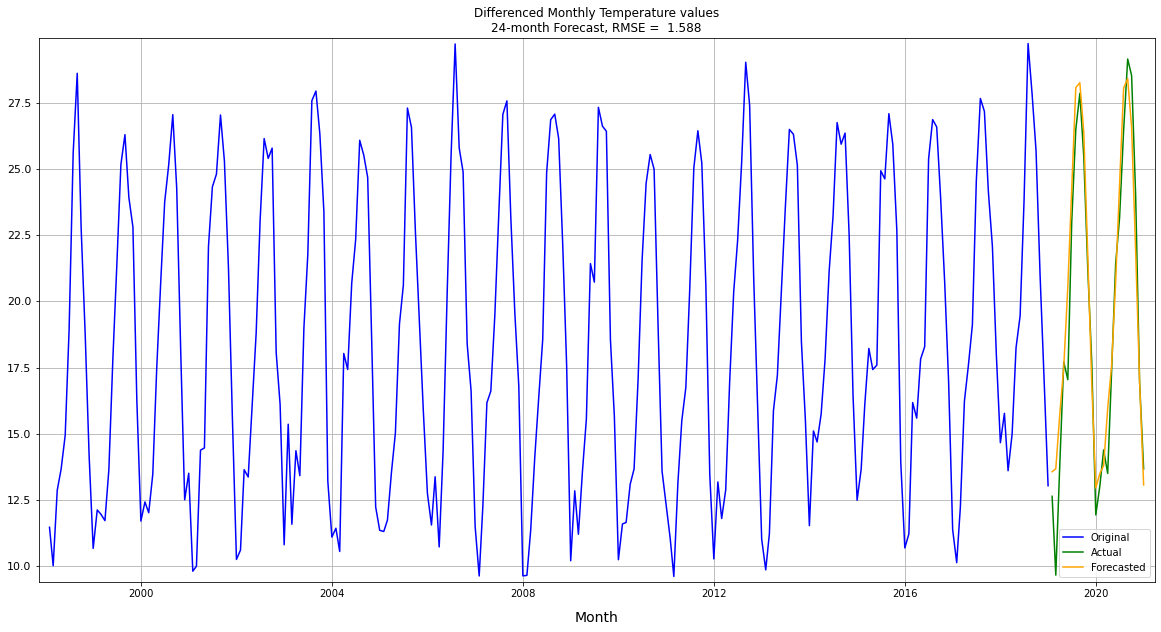

In [26]:
actual = df_rsm.iloc[252:][columns[forecast_on_idx]]

rmse = np.sqrt(np.mean((actual - forecast) ** 2))

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_rsm.iloc[:252][columns[forecast_on_idx]], label="Original", color="blue")
ax.plot(actual, label="Actual", color="green")
ax.plot(forecast, label="Forecasted", color="orange")

ax.set_xlabel("Month")

ax.set_title(
    f"Differenced Monthly {columns[forecast_on_idx]} values\n"
    + f"{len(forecast)}-month Forecast, RMSE = {rmse: .3f}"
)

ax.grid()
ax.legend();

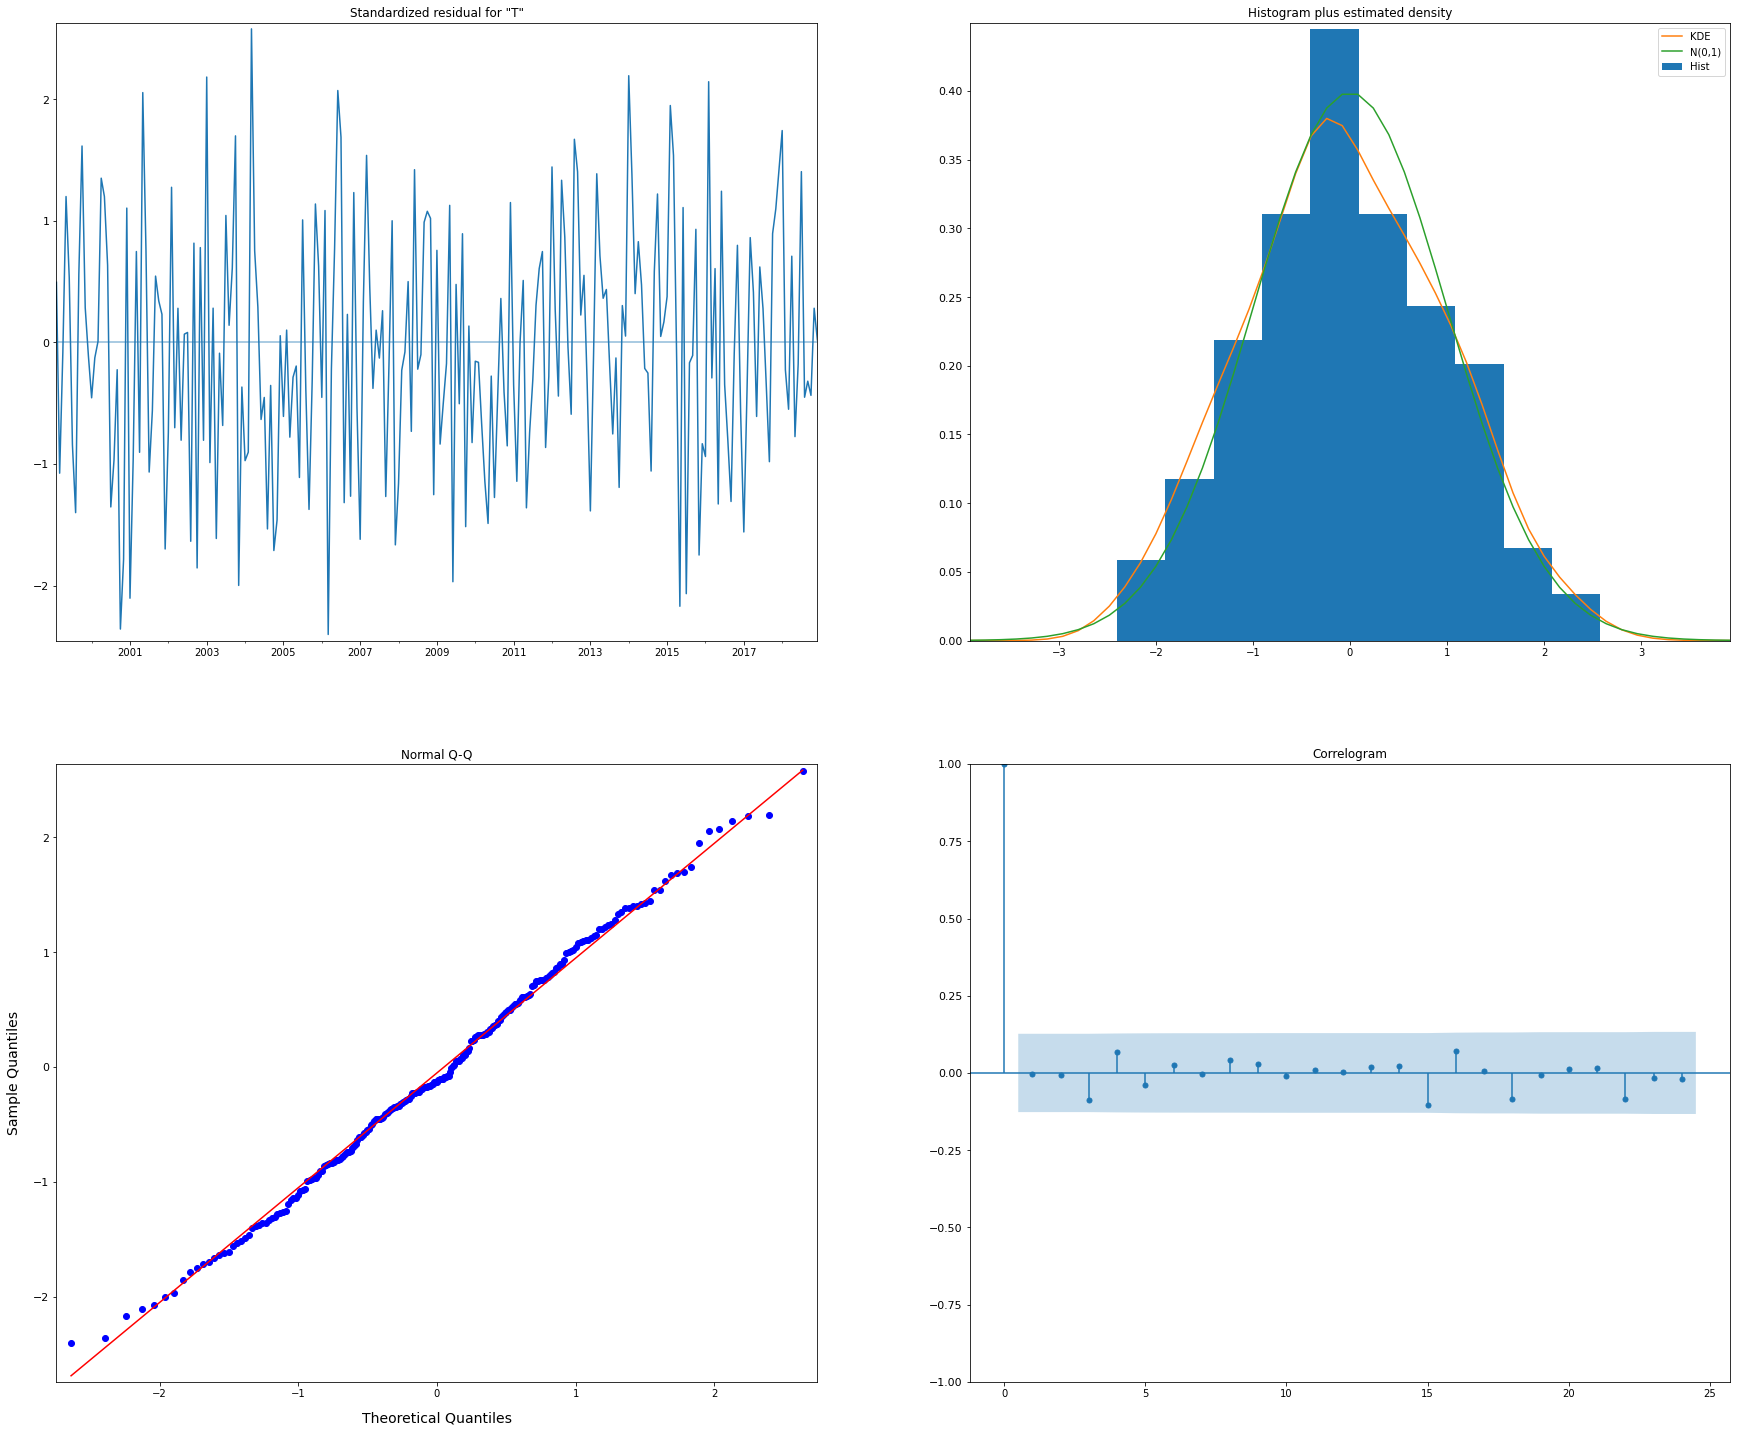

In [27]:
model.plot_diagnostics(lags=24);